# Uncertainty plot

In [30]:
subcortical_regions = [
    "Thalamus",
    "Caudate",
    "Putamen",
    "Pallidum",
    "Hippocampus",
    "Amygdala",
    "Accumbens-area",
]
subcortical_regions = (
    ["Left-" + region for region in subcortical_regions]
    + ["Right-" + region for region in subcortical_regions]
    + subcortical_regions
)

# Cortical regions in DKT atlas
cortical_regions = [
    "bankssts",
    "caudalanteriorcingulate",
    "caudalmiddlefrontal",
    "cuneus",
    "entorhinal",
    "fusiform",
    "inferiorparietal",
    "inferiortemporal",
    "isthmuscingulate",
    "lateraloccipital",
    "lateralorbitofrontal",
    "lingual",
    "medialorbitofrontal",
    "middletemporal",
    "parahippocampal",
    "paracentral",
    "parsopercularis",
    "parsorbitalis",
    "parstriangularis",
    "pericalcarine",
    "postcentral",
    "posteriorcingulate",
    "precentral",
    "precuneus",
    "rostralanteriorcingulate",
    "rostralmiddlefrontal",
    "superiorfrontal",
    "superiorparietal",
    "superiortemporal",
    "supramarginal",
    "frontalpole",
    "temporalpole",
    "transversetemporal",
    "insula",
]
cortical_regions = (
    ["lh-" + region for region in cortical_regions]
    + ["rh-" + region for region in cortical_regions]
    + cortical_regions
)

In [31]:
def nature_style(
    fig, marker_size=8, opacity=1, font_size=14, width=800, height=800, yrange=None
):
    # === Nature style adjustments ===
    fig.update_traces(
        marker=dict(
            size=marker_size, opacity=opacity, line=dict(width=0.25, color="black")
        ),  # clean markers
    )

    fig.update_layout(
        title_text="Probability of False Positive vs Distance to significance threshold",
        title_x=0.5,
        width=width,  # ~single-column Nature width
        height=height,
        font=dict(family="Helvetica", size=font_size),
        plot_bgcolor="white",
        paper_bgcolor="white",
        showlegend=True,
        margin=dict(l=60, r=60, t=50, b=60),
        legend=dict(
            x=0.98,
            y=0.98,
            xanchor="right",
            yanchor="top",
            bgcolor="rgba(255, 255, 255, 0.8)",
            bordercolor="black",
            borderwidth=1,
        ),
        xaxis=dict(
            # title="Sample size",
            linecolor="black",
            ticks="outside",
            tickwidth=1,
            tickcolor="black",
            showgrid=False,
            mirror=True,
        ),
        yaxis=dict(
            # title="Probability of false positive",
            linecolor="black",
            ticks="outside",
            tickwidth=1,
            tickcolor="black",
            showgrid=False,
            mirror=True,
            range=yrange,
        ),
    )
    fig.update_xaxes(
        tickfont=dict(size=12),
        showline=True,
        linewidth=1,
        linecolor="black",
        mirror=True,
        ticks="inside",
        categoryorder="array",
    )
    fig.update_yaxes(
        tickfont=dict(size=12),
        showline=True,
        linewidth=1,
        linecolor="black",
        mirror=True,
        ticks="inside",
    )
    return fig


In [32]:
import plotly.express as px
import pandas as pd
import numpy as np
import rglob
from pathlib import Path

anonymizer = True

root_dir = Path.cwd().parent


def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<living-park>")
    return Path(path_str)


print(f"Running in root dir: {anondir(root_dir)}")
npv_dir = root_dir / "npv" / "csv_all"
print(f"Using NPV dir: {anondir(npv_dir)}")
data_dir = root_dir / "papers_data"
print(f"Using data dir: {anondir(data_dir)}")

Running in root dir: <living-park>
Using NPV dir: <living-park>/npv/csv_all
Using data dir: <living-park>/papers_data


In [33]:
files = rglob.rglob(data_dir, "uncertainty.csv")

In [34]:
df = pd.DataFrame()
for file in files:
    x = pd.read_csv(file)
    x["paper"] = Path(file).parent.name
    df = pd.concat([df, x])

In [35]:
df["significant"] = df["significant"].astype(bool)
df = df[~df["paper"].isin(["Liu_2012", "Current"])]

In [36]:
assert df["p_value"].isnull().sum() == 0
assert df["alpha"].isnull().sum() == 0
assert df["proba_significant"].isnull().sum() == 0
df["proba_non_significant"] = 1 - df["proba_significant"]
df["entropy"] = - (
  df["proba_significant"] * np.where(df["proba_significant"] > 0, np.log(df["proba_significant"]), 0)
  + df["proba_non_significant"] * np.where(df["proba_non_significant"] > 0, np.log(df["proba_non_significant"]), 0)
  )
df["dist"] = df["p_value"] - df["alpha"]
df["abs_dist"] = np.abs(df["dist"])
df["dist_log"] = np.log10(df["abs_dist"] + 1e-10)
df["sign"] = np.sign(df["dist"])

/home/yohan/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log



In [37]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.validator_cache import ValidatorCache

# --- 0) PREP ---
df_ = df.copy()
df_.loc[df_["metric"] == "volume", "metric"] = "cortical volume"

# Ensure stable ordering
metrics = list(df_["metric"].dropna().unique())
studies = list(df_["study"].dropna().unique())

# Optional: enforce a preferred order if you have one
# metrics = ["cortical thickness", "cortical volume", "cortical area", ...]
# studies = ["cross-sectional", "longitudinal"]

# Symbols for papers (same approach as code 2)
SymbolValidator = ValidatorCache.get_validator("scatter.marker", "symbol")
raw_symbols = SymbolValidator.values[2::3][::4]
papers = list(df_["paper"].dropna().unique())
paper_map = {v: f"Article {k}" for k, v in enumerate(df["paper"].unique(), start=1)}
markermap = {p: raw_symbols[i % len(raw_symbols)] for i, p in enumerate(papers)}

# Map each (study, metric) to a subplot position (row/col)
position_map = {
    ("cross-sectional", "subcortical volume"): dict(row=1, col=1),
    ("longitudinal", "subcortical volume"): dict(row=1, col=2),
    ("cross-sectional", "cortical thickness"): dict(row=2, col=1),
    ("cross-sectional", "cortical volume"): dict(row=3, col=1),
    ("longitudinal", "cortical volume"): dict(row=3, col=2),
    ("cross-sectional", "cortical area"): dict(row=4, col=1),
}

# Subplot titles, ordered by row then col (like code 2)
subplot_titles = list(
    map(
        lambda x: (x[0][0] + " " + x[0][1]).capitalize(),
        sorted(position_map.items(), key=lambda x: (x[1]["row"], x[1]["col"])),
    )
)
max_size = df_["sample_size"].max()

fig = make_subplots(
    rows=len(metrics),
    cols=len(studies),
    horizontal_spacing=0.02,
    vertical_spacing=0.035,
    subplot_titles=subplot_titles,
    x_title=r"$p-\alpha$",
    y_title="Decision Entropy",
    shared_yaxes=True,
    shared_xaxes=True,
    specs=[[{}, {}], [{"colspan": 2}, None], [{}, {}], [{"colspan": 2}, None]],
)

cmin = float(df_["entropy"].min())
cmax = float(df_["entropy"].max())

# Show each paper only once in legend
in_legend = set()

colormap = {}
# Colorblind palette https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40
colormap["T"] = "#D81B60"
colormap["F"] = "#1E88E5"
colormap["R"] = "#FFC107"
markermap = dict(zip(df["paper"].unique(), raw_symbols))

for test in df_["test"].unique():
    if test == "T":
        legend = "legend"
    elif test == "F":
        legend = "legend2"
    elif test == "R":
        legend = "legend3"

    for metric in metrics:
        for study in studies:
            sub = df_[
                (df_["metric"] == metric)
                & (df_["study"] == study)
                & (df_["test"] == test)
            ]
            if sub.empty:
                continue

            for paper in sub["paper"].unique():
                sub_p = sub[sub["paper"] == paper]

                legend_name = paper_map[paper]
                legendkey = paper + " " + test
                showlegend = legendkey not in in_legend
                in_legend.add(legendkey)

                fig.add_trace(
                    go.Scatter(
                        x=sub_p["dist"],
                        y=sub_p["entropy"],
                        mode="markers",
                        legend=legend,
                        name=legend_name,
                        showlegend=showlegend,
                        marker=dict(
                            # size=6,
                            opacity=0.5,
                            symbol=markermap.get(paper, "circle"),
                            size=np.log10(sub_p["sample_size"]) * 3,
                            color=colormap[test],
                            coloraxis="coloraxis",  # shared continuous colorbar
                            line=dict(width=0),
                        ),
                        customdata=sub_p[
                            [
                                "region",
                                "metric",
                                "paper",
                                "p_value",
                                "alpha",
                                "dist",
                                "test",
                            ]
                        ].to_numpy(),
                        hovertemplate=(
                            "x (P false positive)=%{x}<br>"
                            "y=%{y}<br>"
                            "region=%{customdata[0]}<br>"
                            "metric=%{customdata[1]}<br>"
                            "paper=%{customdata[2]}<br>"
                            "p=%{customdata[3]}<br>"
                            "alpha=%{customdata[4]}<br>"
                            "dist=%{customdata[5]}<extra></extra>"
                            "test=%{customdata[6]}<extra></extra>"
                        ),
                    ),
                    **position_map[(study, metric)],
                )


opacity = 0.5
yrange = None
font_size = 14

fig.update_traces(marker=dict(opacity=opacity, line=dict(width=0.25, color="black")))

# --- 3) LAYOUT & STYLING ---
font_size = 14

fig.update_layout(
    title_text="Statistical decision entropy vs. distance to the significance threshold",
    title_x=0.5,
    height=1400,
    width=1000,
    font=dict(family="Helvetica", size=font_size),
    plot_bgcolor="white",
    paper_bgcolor="white",
    showlegend=True,
    margin=dict(l=60, r=10, t=50, b=60),
    legend=dict(
        title="Significance",
        orientation="h",
        x=0.5,
        y=-0.08, # Moved up slightly
        xanchor="center",
        yanchor="bottom",
    ),
)

fig.update_yaxes(
    range=[-0.05, 1.05],
    tickfont=dict(size=12),
    showline=True,
    linewidth=1,
    linecolor="black",
    mirror=True,
    ticks="inside",
)
log_scale=False
if log_scale:
    type_scale="log"
    exponentformat="power"
    range_x=[-4.1, 0.1]
else:
    type_scale="linear"
    exponentformat=None
    range_x=[-1.1, 1.1]
    

fig.update_xaxes(
    type=type_scale,
    exponentformat=exponentformat,
    range=range_x,
    tickfont=dict(size=12),
    showline=True,
    linewidth=1,
    linecolor="black",
    mirror=True,
    ticks="inside",
    showticklabels=True,
)

legend_font_size = 12
y_legend = -0.1
y_legend_space = -0.015

fig.update_layout(
    legend=dict(
        font=dict(size=legend_font_size),
        orientation="h",
        yanchor="bottom",
        y=y_legend,
        xanchor="left",
        x=0,
        title="T test",
        tracegroupgap=10,
        bordercolor="black",
        borderwidth=0,
        bgcolor="rgba(0,0,0,0)",
    ),
    legend2=dict(
        font=dict(size=legend_font_size),
        orientation="h",
        yanchor="bottom",
        y=y_legend + y_legend_space,
        xanchor="left",
        x=0,
        title="F test",
        tracegroupgap=10,
        bordercolor="black",
        borderwidth=0,
        entrywidth=0,
        entrywidthmode="pixels",
        bgcolor="rgba(0,0,0,0)",
    ),
    legend3=dict(
        font=dict(size=legend_font_size),
        orientation="h",
        yanchor="bottom",
        y=y_legend + y_legend_space * 2,
        xanchor="left",
        x=0,
        title="R test",
        tracegroupgap=10,
        bordercolor="black",
        borderwidth=0,
        bgcolor="rgba(0,0,0,0)",
    ),
)

# Add rectangle to gather legend
fig.add_shape(
    type="rect",
    x0=-0.005,
    y0=-0.07,
    x1=1.0,
    y1=-0.13,
    fillcolor="rgba(0,0,0,0)",
    line=dict(color="black", width=1),
    xref="paper",
    yref="paper",
    opacity=0.5,
)

fig

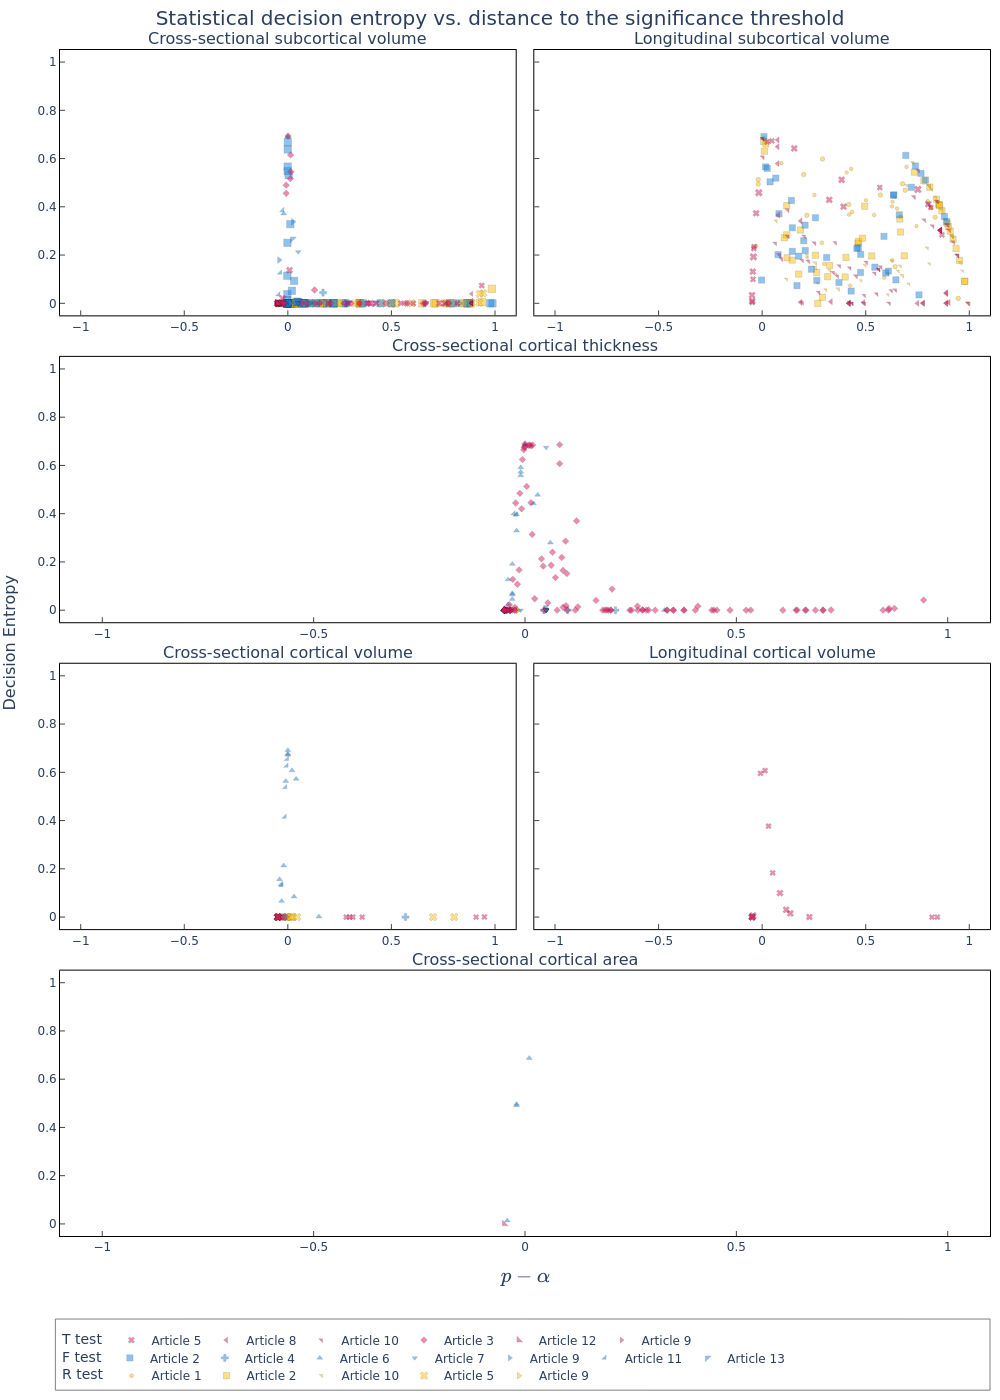

In [38]:
from IPython.display import Image, display

fig.write_image("figure-entropy-paper.pdf")
display(Image(fig.to_image()))

In [39]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.validator_cache import ValidatorCache
import numpy as np
import pandas as pd

log_scale = False

# --- 0) PREP ---
df_ = df.copy()
df_.loc[df_["metric"] == "volume", "metric"] = "cortical volume"

# Ensure stable ordering
metrics = list(df_["metric"].dropna().unique())
studies = list(df_["study"].dropna().unique())

# Symbols for papers
SymbolValidator = ValidatorCache.get_validator("scatter.marker", "symbol")
raw_symbols = SymbolValidator.values[2::3][::4]
papers = list(df_["paper"].dropna().unique())
paper_map = {v: f"{k}" for k, v in enumerate(df["paper"].unique(), start=1)}
markermap = {p: raw_symbols[i % len(raw_symbols)] for i, p in enumerate(papers)}

# Map each (study, metric) to a subplot position (row/col)
position_map = {
    ("cross-sectional", "subcortical volume"): dict(row=1, col=1),
    ("longitudinal", "subcortical volume"): dict(row=1, col=2),
    ("cross-sectional", "cortical thickness"): dict(row=2, col=1),
    ("cross-sectional", "cortical volume"): dict(row=3, col=1),
    ("longitudinal", "cortical volume"): dict(row=3, col=2),
    ("cross-sectional", "cortical area"): dict(row=4, col=1),
}

# Subplot titles
subplot_titles = list(
    map(
        lambda x: (x[0][0] + " " + x[0][1]).capitalize(),
        sorted(position_map.items(), key=lambda x: (x[1]["row"], x[1]["col"])),
    )
)
max_size = df_["sample_size"].max()

fig = make_subplots(
    rows=len(metrics),
    cols=len(studies),
    horizontal_spacing=0.02,
    vertical_spacing=0.035,
    subplot_titles=subplot_titles,
    y_title="Statistical decision entropy",
    x_title=r"$p-\alpha$",
    shared_yaxes=True,
    shared_xaxes=True,
    specs=[[{}, {}], [{"colspan": 2}, None], [{}, {}], [{"colspan": 2}, None]],
)

# --- 1) ADD DUMMY TRACES FOR LEGEND ---
# This ensures "Significant" and "Non-significant" appear in the legend
fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode="markers",
    marker=dict(size=10, color="#1E88E5", symbol="circle"),
    name="Significant",
    showlegend=True,
))

fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode="markers",
    marker=dict(size=10, color="#D84C4C", symbol="circle"),
    name="Non-significant",
    showlegend=True,
))


# --- 2) ADD DATA TRACES ---
for metric in metrics:
    for study in studies:
        sub = df_[(df_["metric"] == metric) & (df_["study"] == study)]
        if sub.empty:
            continue

        for paper in sub["paper"].unique():
            sub_p = sub[sub["paper"] == paper]

            if log_scale:
                x = sub_p["abs_dist"]
            else:
                x = sub_p["dist"]
            
            fig.add_trace(
                go.Scatter(
                    x=x,
                    y=sub_p["entropy"],
                    mode="markers",
                    name=paper_map[paper], 
                    showlegend=False, # Hide individual data traces from legend
                    marker=dict(
                        opacity=0.5,
                        symbol=markermap.get(paper, "circle"),
                        size=np.log10(sub_p["sample_size"]) * 3,
                        # Map boolean to color string
                        color=sub_p["significant"].map({
                            True: "#1E88E5", 
                            False: "#D84C4C"
                        }),
                        line=dict(width=0.25, color="black"),
                    ),
                    customdata=sub_p[
                        ["region", "metric", "paper", "p_value", "alpha", "dist"]
                    ].to_numpy(),
                    hovertemplate=(
                        "<b>%{customdata[2]}</b><br>"
                        "P(FP)=%{x:.2f}<br>"
                        "y=%{y:.2f}<br>"
                        "Region: %{customdata[0]}<br>"
                        "Metric: %{customdata[1]}<br>"
                        "p=%{customdata[3]:.2e}, alpha=%{customdata[4]}<br>"
                        "dist=%{customdata[5]:.2e}<extra></extra>"
                    ),
                ),
                **position_map[(study, metric)],
            )

# --- 3) LAYOUT & STYLING ---
font_size = 14

fig.update_layout(
    title_text="Statistical decision entropy vs. distance to the significance threshold",
    title_x=0.5,
    height=1400,
    width=1000,
    font=dict(family="Helvetica", size=font_size),
    plot_bgcolor="white",
    paper_bgcolor="white",
    showlegend=True,
    margin=dict(l=60, r=10, t=50, b=60),
    legend=dict(
        title="",
        orientation="h",
        x=0.5,
        y=-0.08, # Moved up slightly
        xanchor="center",
        yanchor="bottom",
    ),
)

fig.update_yaxes(
    range=[-0.05, 1.05],
    tickfont=dict(size=12),
    showline=True,
    linewidth=1,
    linecolor="black",
    mirror=True,
    ticks="inside",
)

if log_scale:
    type_scale="log"
    exponentformat="power"
    range_x=[-4.1, 0.1]
else:
    type_scale="linear"
    exponentformat=None
    range_x=[-1.1, 1.1]
    

fig.update_xaxes(
    type=type_scale,
    exponentformat=exponentformat,
    range=range_x,
    tickfont=dict(size=12),
    showline=True,
    linewidth=1,
    linecolor="black",
    mirror=True,
    ticks="inside",
    showticklabels=True,
)



fig.show()

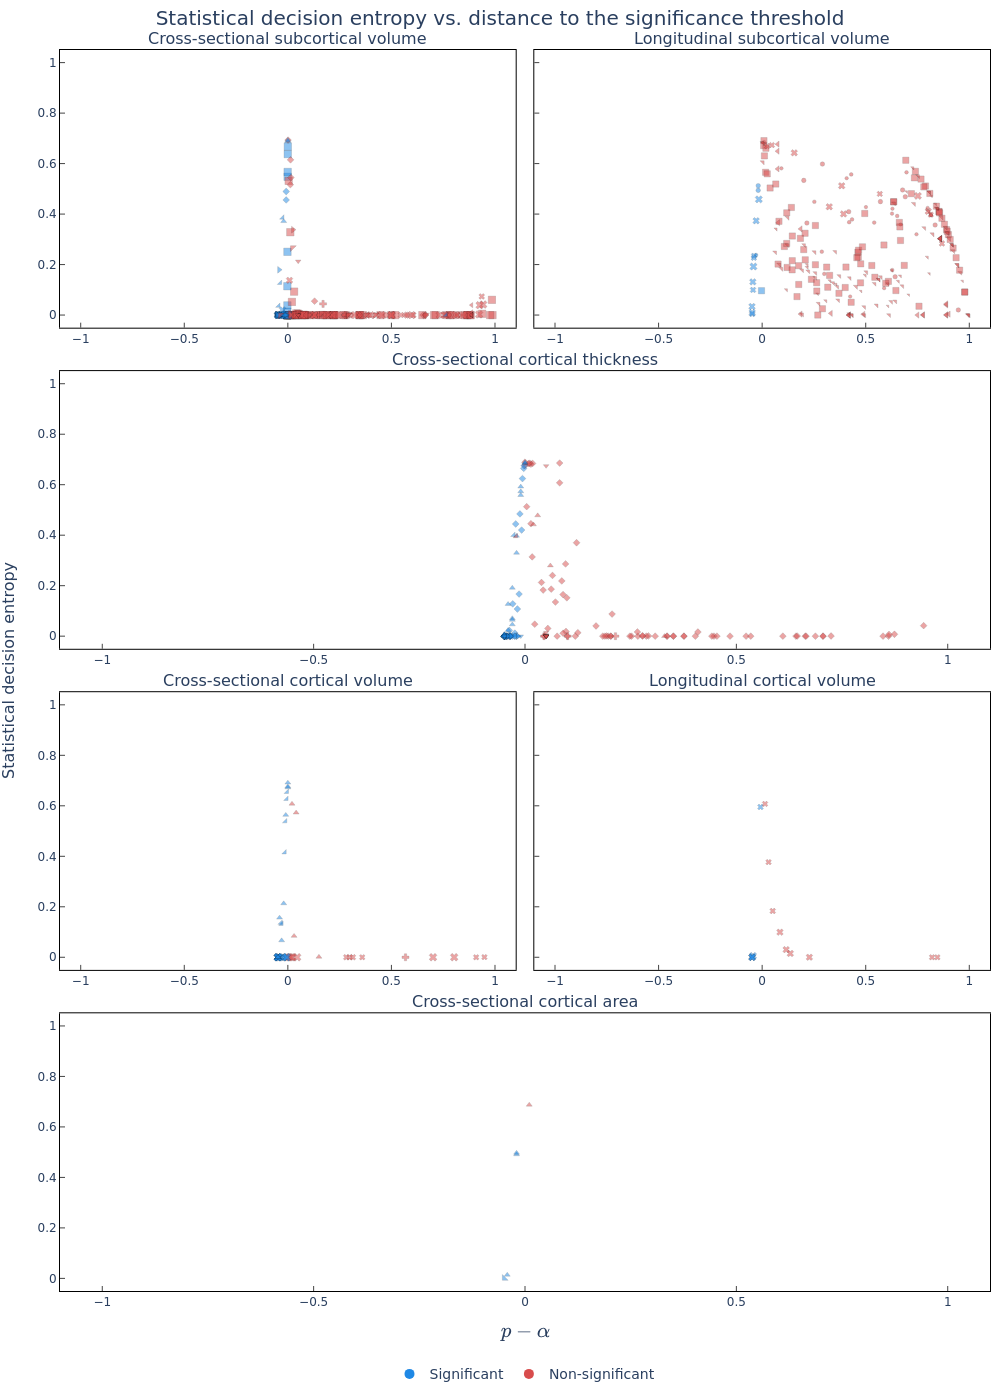

In [40]:
from IPython.display import Image, display

fig.write_image("figure-entropy-binary.pdf")
display(Image(fig.to_image()))